## change point & peak 분석

In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from datetime import datetime

import seaborn as sns

# 시각화 사용자 설정
from matplotlib import rcParams
sns.set_style('whitegrid')
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [330]:
# 크롤링 start_date, end_date
start_date='2020-10-01'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
end_date='2021-02-01'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')

In [331]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [332]:
model_samsung = pd.DataFrame()
# 삼성 차트 데이터
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# S&P 500
snp_500_ = yf.download("^GSPC", start=start_date, end=end_date)
snp_500_.columns = ['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Close','snp_500_Adj Close','snp_500_Volume']
snp_500_ = snp_500_.drop(['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Adj Close','snp_500_Volume'], axis=1)

# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)

# 삼성 차트 데이터
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_samsung.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_samsung['macd'] = macd
model_samsung['macdsignal9'] = macdsignal9
model_samsung['macdhist'] = macdhist

MSCI_KR = fdr.DataReader('156080', start_date,end_date) #MSCI KOREA
MSCI_KR = MSCI_KR.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
MSCI_KR.columns = ['MSCI_KR']

# 미국 국채 수익률 (5년)
treasury_5y_ = yf.download("^FVX", start=start_date, end=end_date)
treasury_5y_.columns = ['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Close','treasury_5y_Adj Close','treasury_5y_Volume']
treasury_5y_ = treasury_5y_.drop(['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Adj Close','treasury_5y_Volume'], axis=1)

# SOX 지수 엔비디아(8.9%), 텍사스인스트루먼트(8.6%), 퀄컴(7.7%), 인텔(7.4%) 반도체장비기업 18.52%
SOXX = yf.download("SOXX", start=start_date, end=end_date)
SOXX.columns = ['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Close','SOXX_Adj Close','SOXX_Volume']
SOXX = SOXX.drop(['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Adj Close','SOXX_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [333]:
#model_samsung['US'] = exchange_rate_usd_
model_samsung['SNP500'] = snp_500_
model_samsung['NASDAQ'] = nasdaq_
model_samsung['MSCI_KR'] = MSCI_KR
model_samsung['TREASURY_5Y']=treasury_5y_
model_samsung['SOXX'] = SOXX

In [334]:
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거

In [335]:
maxClose = model_samsung['Close'].max()
maxSNP500 = model_samsung['SNP500'].max()
maxSOXX = model_samsung['SOXX'].max()

In [336]:
maxClose
maxSNP500
maxSOXX

424.54998779296875

In [337]:
model_samsung["rev_Close"] = maxClose- model_samsung['Close']
model_samsung["rev_SNP500"] = maxSNP500- model_samsung['SNP500']
model_samsung["rev_SOXX"] = maxSOXX- model_samsung['SOXX']

In [338]:
model_samsung

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist,SNP500,NASDAQ,MSCI_KR,TREASURY_5Y,SOXX,rev_Close,rev_SNP500,rev_SOXX
날짜,,,,,,,,,,,,,,,,
2020-11-20,63900,65200,63900,64700,15068682,1265.269666,469.578996,795.690670,3557.540039,11854.969727,16200,0.376,347.369995,26300,297.820068,77.179993
2020-11-23,64800,67800,64700,67500,27134398,1532.217712,682.106739,850.110973,3577.590088,11880.629883,16575,0.388,352.320007,23500,277.770020,72.229980
2020-11-24,67900,69500,67000,67700,32158235,1739.858287,893.657048,846.201238,3635.409912,12036.790039,16730,0.397,354.239990,23300,219.950195,70.309998
2020-11-25,67900,68300,66500,66600,32447065,1794.962916,1073.918222,721.044694,3629.649902,12094.400391,16510,0.389,353.459991,24400,225.710205,71.089996
2020-11-30,68400,68600,66700,66700,43811016,1963.622733,1514.109278,449.513455,3621.629883,12198.740234,16540,0.362,361.809998,24300,233.730225,62.739990
2020-12-01,67100,68300,67100,67800,22327173,1978.065269,1606.900476,371.164793,3662.449951,12355.110352,16685,0.427,367.779999,23200,192.910156,56.769989
2020-12-02,68400,69900,68300,69500,29703942,2102.451127,1706.010606,396.440521,3669.010010,12349.370117,17120,0.423,368.859985,21500,186.350098,55.690002
2020-12-03,70100,70500,69300,69700,23677989,2191.899294,1803.188344,388.710950,3666.719971,12377.179688,17315,0.405,369.339996,21300,188.640137,55.209991
2020-12-04,70400,72100,70100,71500,28130533,2380.590601,1918.668795,461.921806,3699.120117,12464.230469,17680,0.423,379.410004,19500,156.239990,45.139984


In [339]:
# 차트 비교분석을 위한 정규화
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(model_samsung)
output = min_max_scaler.transform(model_samsung)
output = pd.DataFrame(output, columns=model_samsung.columns, index=list(model_samsung.index.values))
print(output.head())

                Open      High       Low     Close    Volume      macd  \
2020-11-20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-11-23  0.034091  0.082278  0.031250  0.106464  0.160368  0.066354   
2020-11-24  0.151515  0.136076  0.121094  0.114068  0.227141  0.117966   
2020-11-25  0.151515  0.098101  0.101562  0.072243  0.230980  0.131663   
2020-11-30  0.170455  0.107595  0.109375  0.076046  0.382021  0.173585   

            macdsignal9  macdhist    SNP500    NASDAQ   MSCI_KR  TREASURY_5Y  \
2020-11-20     0.000000  0.878209  0.000000  0.000000  0.000000     0.147651   
2020-11-23     0.051011  0.902074  0.067323  0.014408  0.073529     0.228188   
2020-11-24     0.101787  0.900359  0.261466  0.102088  0.103922     0.288591   
2020-11-25     0.145053  0.845475  0.242126  0.134435  0.060784     0.234899   
2020-11-30     0.250708  0.726400  0.215197  0.193019  0.066667     0.053691   

                SOXX  rev_Close  rev_SNP500  rev_SOXX  
2020-11-20  0.0000

## peak 분석


In [340]:
start_date = '2020-10-01'
end_date   = '2021-02-01'

In [341]:
Close_samsung= output['Close'][start_date:end_date]

In [342]:
min_Close_samsung= output['rev_Close'][start_date:end_date]

In [343]:
price_peak_limit = 0.1
peaks, properties = find_peaks(Close_samsung, height=price_peak_limit)

print(f'Index of each peaks : {Close_samsung.index[peaks]}')
print(f'Height of each peaks : {properties["peak_heights"]}')

Index of each peaks : DatetimeIndex(['2020-11-24', '2020-12-07', '2020-12-09', '2020-12-15',
               '2020-12-28', '2021-01-05', '2021-01-11', '2021-01-21',
               '2021-01-25'],
              dtype='datetime64[ns]', freq=None)
Height of each peaks : [0.11406844 0.31178707 0.34980989 0.3460076  0.53231939 0.73003802
 1.         0.88973384 0.9391635 ]


In [344]:
price_peak_limit = 0.1
peaks2, properties2 = find_peaks(min_Close_samsung, height=price_peak_limit)

print(f'Index of each peaks : {min_Close_samsung.index[peaks2]}')
print(f'Height of each peaks : {properties2["peak_heights"]}')

Index of each peaks : DatetimeIndex(['2020-11-25', '2020-12-08', '2020-12-10', '2020-12-22',
               '2020-12-29', '2021-01-06', '2021-01-19', '2021-01-22'],
              dtype='datetime64[ns]', freq=None)
Height of each peaks : [0.92775665 0.7338403  0.68821293 0.71102662 0.48288973 0.33460076
 0.15209125 0.15969582]


In [345]:
new_peaks = np.concatenate((peaks, peaks2),axis=0)
new_peaks = np.sort(new_peaks)
new_peaks

array([ 2,  3,  9, 10, 11, 12, 15, 20, 22, 23, 26, 27, 30, 35, 37, 38, 39],
      dtype=int64)

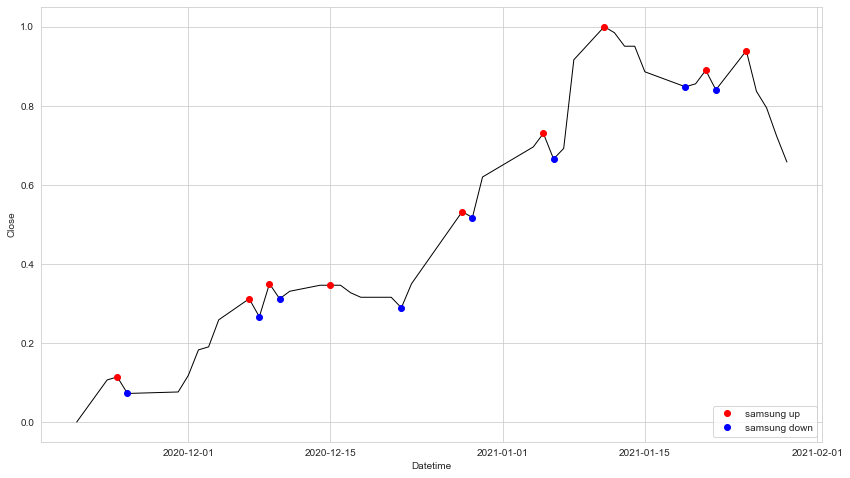

In [346]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
#plt.plot_date(output['macd'].index, output['macd'], 'g-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks], Close_samsung[peaks], 'ro', label = 'samsung up')
plt.plot_date(Close_samsung.index[peaks2], Close_samsung[peaks2], 'bo', label = 'samsung down')

plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()

In [347]:
# max peak와 min peak 찍어보기

In [348]:
Close_SNP500= output['SNP500'][start_date:end_date]
Close_SOXX= output['SOXX'][start_date:end_date]

In [349]:
min_SNP500= output['rev_SNP500'][start_date:end_date]
min_SOXX= output['rev_SOXX'][start_date:end_date]

In [350]:
price_peak_limit = 0.1
peaks3, properties3 = find_peaks(Close_SNP500, height=price_peak_limit)
peaks4, properties4 = find_peaks(Close_SOXX, height=price_peak_limit)

peaks5, properties5 = find_peaks(min_SNP500, height=price_peak_limit)
peaks6, properties6 = find_peaks(min_SOXX, height=price_peak_limit)

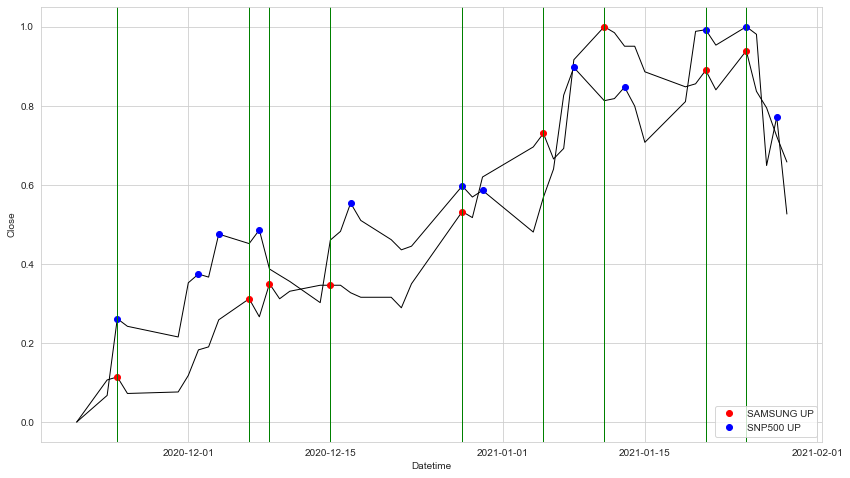

In [351]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
plt.plot_date(Close_SNP500.index, Close_SNP500, 'k-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks], Close_samsung[peaks], 'ro', label = 'SAMSUNG UP')
plt.plot_date(Close_SNP500.index[peaks3], Close_SNP500[peaks3], 'bo', label = 'SNP500 UP')

for date in Close_samsung.index[peaks]:
    plt.axvline(x=date, color='g', linestyle='-', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()
# 삼성전자와 S&P500의 MAX PEAK의 비교 -> 어느정도 유사점이 발견

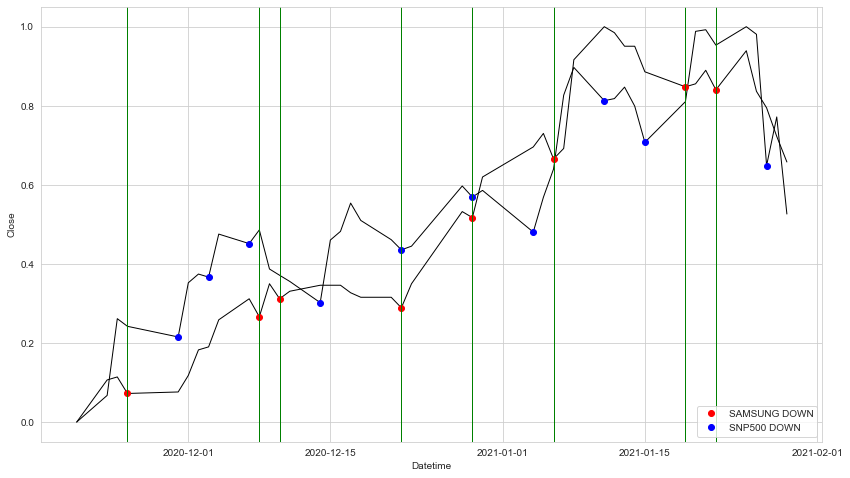

In [352]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
plt.plot_date(Close_SNP500.index, Close_SNP500, 'k-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks2], Close_samsung[peaks2], 'ro', label = 'SAMSUNG DOWN')
plt.plot_date(Close_SNP500.index[peaks5], Close_SNP500[peaks5], 'bo', label = 'SNP500 DOWN')

for date in Close_samsung.index[peaks2]:
    plt.axvline(x=date, color='g', linestyle='-', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()
# 삼성전자와 S&P500의 MIN PEAK의 비교 

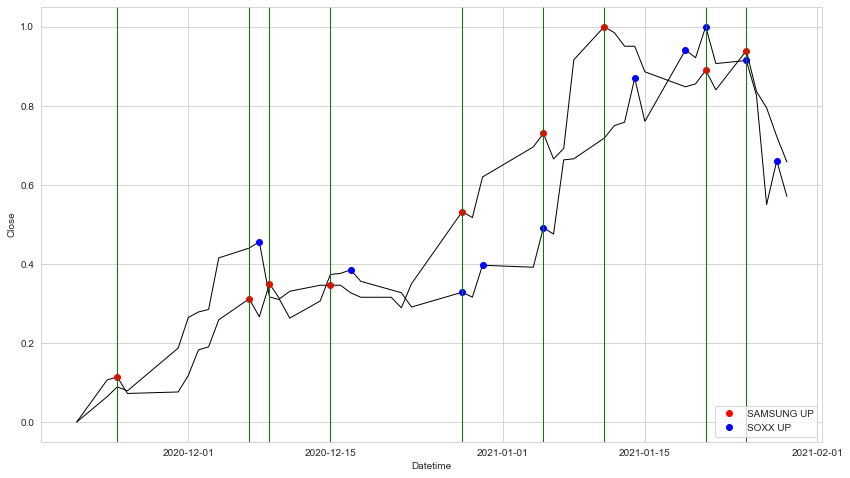

In [353]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
plt.plot_date(Close_SOXX.index, Close_SOXX, 'k-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks], Close_samsung[peaks], 'ro', label = 'SAMSUNG UP')
plt.plot_date(Close_SOXX.index[peaks4], Close_SOXX[peaks4], 'bo', label = 'SOXX UP')

for date in Close_samsung.index[peaks]:
    plt.axvline(x=date, color='g', linestyle='-', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()
# 삼성전자와 SOX의 MAX PEAK의 비교 

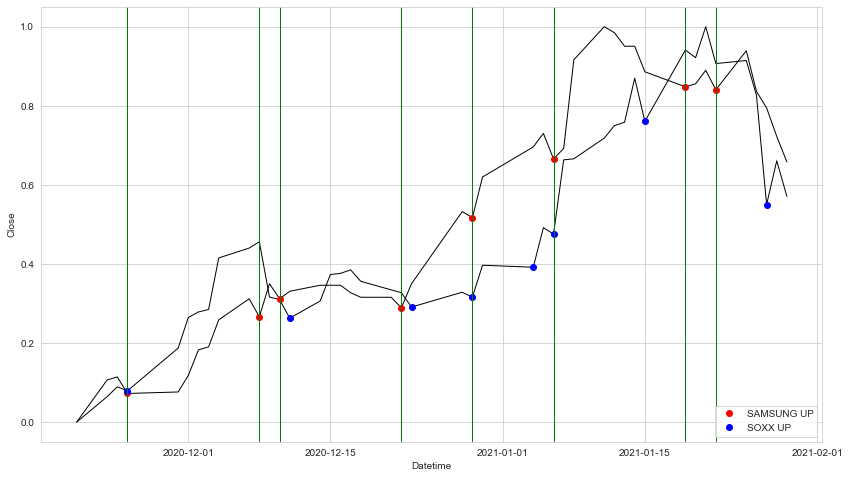

In [354]:
plt.figure(figsize = (14, 8))
plt.plot_date(Close_samsung.index, Close_samsung, 'k-', linewidth = 1)
plt.plot_date(Close_SOXX.index, Close_SOXX, 'k-', linewidth = 1)
plt.plot_date(Close_samsung.index[peaks2], Close_samsung[peaks2], 'ro', label = 'SAMSUNG UP')
plt.plot_date(Close_SOXX.index[peaks6], Close_SOXX[peaks6], 'bo', label = 'SOXX UP')

for date in Close_samsung.index[peaks2]:
    plt.axvline(x=date, color='g', linestyle='-', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend(loc = 4)
plt.show()
# 삼성전자와 SOX의 MINX PEAK의 비교 

In [355]:
from bs4 import BeautifulSoup
import requests

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

#뉴스 데이터 가져오기(관련기사는 제거)
def getPageNewsData(page) :
    url = news_url + "&page=" + str(page)
    response = requests.get(url)
    response.encoding = 'euc-kr' #한글깨짐방지
    soup = BeautifulSoup(response.text, 'html.parser')
    
    table = soup.find('table')
    rlist = table.find_all('tr', class_="relation_lst")
    for tr in rlist :
        tr.decompose()

    df = pd.read_html(str(table), header=0)[0].dropna()
    return df

#마지막 페이지 번호
def getLastPageNum(soup) :
    return int(soup.find("table", class_="Nnavi").find("td", class_="pgRR").find("a").get("href").split("&")[1].split("=")[1])

In [356]:
code = '005930'
news_url = 'https://finance.naver.com/item/news_news.nhn?code='+code
startDate = '2020.09.01'

#기사 가져오기
response = requests.get(news_url)
soup = BeautifulSoup(response.text, 'html.parser')

#마지막 페이지 가져오기
last_page = getLastPageNum(soup)

#페이지별로 loop 돌면서 dataframe으로 만들기
last_index = last_page+1

news_df = getPageNewsData(1).dropna()
for i in range(2, last_index) :
    tmp_df = getPageNewsData(i)
    add_df = tmp_df[tmp_df['날짜'] > startDate]
    news_df = pd.concat([news_df, add_df], ignore_index=True)
    if len(add_df) < len(tmp_df) : 
        break
        
#추가 : 중복제거
news_df = news_df.drop_duplicates()

# 데이터셋으로 쓸 dataframe 만들기
# 날짜 / 제목 / updown
news_df['date'] = news_df['날짜'].str.split(' ').str[0]
pivot_df = news_df.drop(['정보제공', '날짜'], axis=1).rename({'제목':'subject'}, axis='columns')
pivot_df

,subject,date
0,"삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정",2021.02.23
1,"삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다",2021.02.23
2,"삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대",2021.02.23
3,"""삼성 카메라 이 정도야?""…'소니' 따라 잡을 승부수 내놨다",2021.02.23
4,글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정,2021.02.23
...,...,...
4005,"삼성전자 ""35조2000억원 규모로 반도체·디스플레이 부문 시설투자""",2020.10.29
4006,"[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원",2020.10.29
4007,[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 58.8...,2020.10.29
4008,[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈',2020.10.29


In [357]:
#중복제거하면 인덱스가 빵구가 나서 인덱스 초기화 후 다시 매꿔주기
pivot_df= pivot_df.reset_index()
del pivot_df["index"]
pivot_df

,subject,date
0,"삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정",2021.02.23
1,"삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다",2021.02.23
2,"삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대",2021.02.23
3,"""삼성 카메라 이 정도야?""…'소니' 따라 잡을 승부수 내놨다",2021.02.23
4,글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정,2021.02.23
...,...,...
3139,"삼성전자 ""35조2000억원 규모로 반도체·디스플레이 부문 시설투자""",2020.10.29
3140,"[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원",2020.10.29
3141,[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 58.8...,2020.10.29
3142,[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈',2020.10.29


In [369]:
new_peaks

array([ 2,  3,  9, 10, 11, 12, 15, 20, 22, 23, 26, 27, 30, 35, 37, 38, 39],
      dtype=int64)

In [374]:
model_samsung = model_samsung.reset_index()

In [383]:
size = len(pivot_df)
for day in new_peaks:
    for s in range(size):
        date = model_samsung['날짜'][day].strftime('%Y.%m.%d')
        if(pivot_df['date'][s].strip()==date.strip()):
            print(pivot_df['date'] + pivot_df['subject'])

0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...           

0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...           

0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...           

Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                

0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...           

Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                

0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...           

Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                

0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...           

Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                

Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                              ...                        
3139     2020.10.29삼성전자 "35조2000억원 규모로 반도체·디스플레이 부문 시설투자"
3140            2020.10.29[속보] 삼성전자, 3분기 반도체 영업익 5조5400억원
3141    2020.10.29[속보] 삼성전자 3분기 영업이익 12조3533억원…작년 대비 5...
3142    2020.10.29[속보]삼성전자 3·4분기 영업이익 12.35조원···'어닝서프라이즈'
3143                2020.10.29삼성전자, 3분기 가전사업 영업익 1.56조 기록
Length: 3144, dtype: object
0                  2021.02.23삼성전자, 삼성웰스토리 대신할 외부 급식 업체 선정
1         2021.02.23삼성 ‘충남’, SK ‘용인’... 첨단 소부장 단지 기업이 이끈다
2              2021.02.23삼성전자, 갤럭시 보안 업데이트 최소 4년 이상 지원 확대
3            2021.02.23"삼성 카메라 이 정도야?"…'소니' 따라 잡을 승부수 내놨다
4                2021.02.23글로벌 100대 혁신기업에 삼성·LG전자 등 5곳 선정
                